In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# download dataset
import gdown

url = 'https://drive.google.com/file/d/1M2HkGHaxdLr8qPXTRMQTKVtQ1N3zTpTy/view?usp=sharing'
gdown.download(url=url, output='dataset.zip', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1M2HkGHaxdLr8qPXTRMQTKVtQ1N3zTpTy
To: /content/dataset.zip
100%|██████████| 143M/143M [00:01<00:00, 97.3MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/image/
  inflating: dataset/test/image/LC_GS_AP25_34801025_408_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34801025_534_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802003_016_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802003_333_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802003_491_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802014_064_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802014_137_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_34802014_346_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_35803044_530_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_35803045_065_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_35803045_087_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_35803045_529_2019_FGT.tif  
  inflating: dataset/test/image/LC_GS_AP25_3

In [ ]:
import glob                                                                                                                     # 파일 목록을 보여주기 위한 라이브러리
from tqdm import tqdm                                                                                                     # 반복수행에서 진행 단계를 보여주기 위한 라이브러리
import shutil                                                                                                                    # 파일 복사, 이동 등의 명령을 위한 라이브러리
from PIL import Image                                                                                                       # 이미지 파일 처리 라이브러리
import numpy as np                                                                                                          # 수치연산 라이브러리
import tensorflow as tf                                                                                                       # 텐서플로우 딥러닝 프레임워크 
import random                                                                                                                 # 난수 생성 라이브러리
import matplotlib.pyplot as plt                                                                                             # 시각화 라이브러리

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Add, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 123                                                                                                                      # 이하 무작위로 결정되는 요소들의 난수를 고정하여 재현 가능하게 설정
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# train, test 데이터셋 폴더 경로 지정
train_image_dir = 'dataset/train/image'
train_mask_dir = 'dataset/train/mask'
test_image_dir = 'dataset/test/image'
test_mask_dir = 'dataset/test/mask'

# 폴더내 파일 경로 지정
# image와 mask 경로를 동일한 순서로 지정하기 위해 path에 str 함수 replace 적용
train_image_paths = glob.glob(f'{train_image_dir}/*.tif')
train_mask_paths = [path.replace('/image/', '/mask/') for path in train_image_paths]

test_image_paths = glob.glob(f'{test_image_dir}/*.tif')
test_mask_paths = [path.replace('/image/', '/mask/') for path in test_image_paths]

# 데이터 개수 확인
print('train image:', len(train_image_paths))
print('train mask:', len(train_mask_paths))
print('test image:', len(test_image_paths))
print('test mask:', len(test_mask_paths))

train image: 300
train mask: 300
test image: 181
test mask: 181


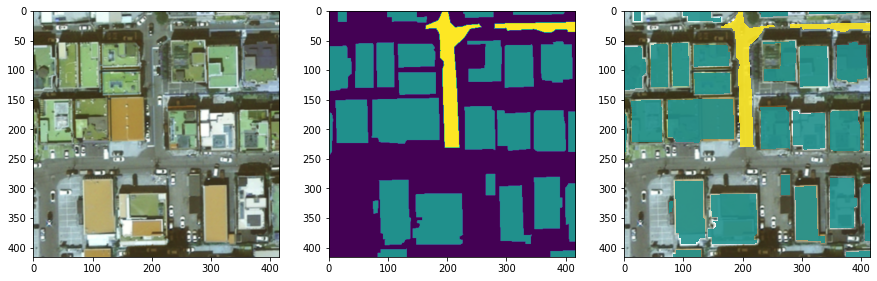

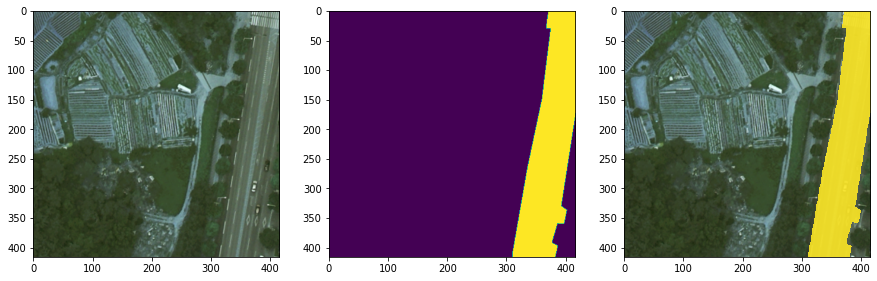

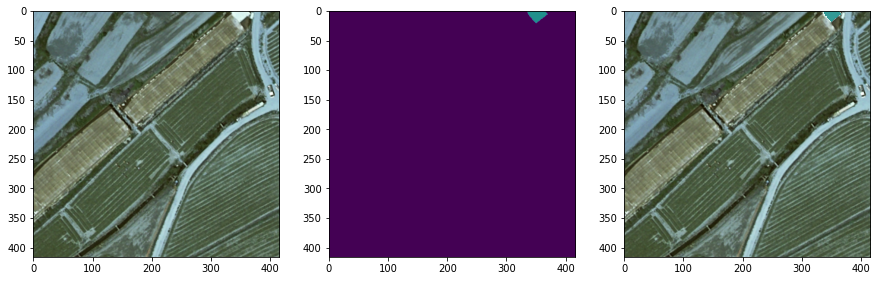

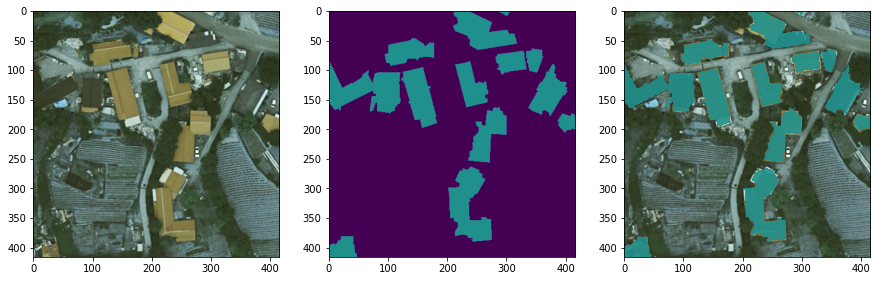

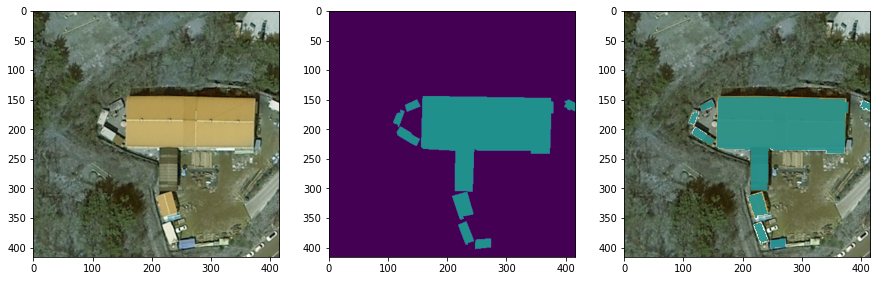

In [ ]:
# Visual image, mask
for train_image_path in train_image_paths[:5]:
    train_mask_path = train_image_path.replace('/image/', '/mask/')

    image = np.array(Image.open(train_image_path))
    mask = np.array(Image.open(train_mask_path))
    mask_ = np.where(mask>0, mask, np.nan)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.imshow(image)
    ax2.imshow(mask, vmin=0, vmax=2)
    ax3.imshow(image)
    ax3.imshow(mask_, vmin=0, vmax=2, alpha=0.9)
    plt.show()
    plt.close('all')


In [ ]:
NUM_CLASS = 3 # background(0), building(1), road(2)
SIZE = 416 # (416, 416, 3)
BATCH_SIZE = 2

In [ ]:
def make_image_array(image_paths, image_size):
    X, y = [], []
    for image_path in image_paths:
        mask_path = image_path.replace('/image/', '/mask/')

        image = np.array(Image.open(image_path).resize(image_size), np.float32)
        image = np.expand_dims(image, axis=0)

        mask = np.array(Image.open(mask_path).resize(image_size), np.float32)
        mask = np.expand_dims(mask, axis=0)

        X.append(image)
        y.append(mask)

    X = np.concatenate(X, axis=0) / 255.
    y = np.concatenate(y, axis=0)

    return X, y

X_train, y_train = make_image_array(train_image_paths, (SIZE,SIZE))
X_test, y_test = make_image_array(test_image_paths, (SIZE,SIZE))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(300, 416, 416, 3) (300, 416, 416) (181, 416, 416, 3) (181, 416, 416)


In [ ]:
# UNet
def UNet(input_shape, num_class):
    # Encoder
    inputs = Input(shape=input_shape)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(inputs)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)

    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool1)
    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)

    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool2)
    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3)

    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool3)
    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bridge
    bridge = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool4)

    # Decoder
    up4 = Conv2DTranspose(filters = 512, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(bridge)
    merge4 = concatenate([enc4, up4], axis = 3)
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge4)
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec4)

    up3 = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec4)
    merge3 = concatenate([enc3, up3], axis = 3)
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge3)
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec3)

    up2 = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec3)
    merge2 = concatenate([enc2, up2], axis = 3)
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge2)
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec2)

    up1 = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec2)
    merge1 = concatenate([enc1, up1], axis = 3)
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge1)
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec1)

    outputs = Conv2D(filters = num_class, kernel_size = 1, activation = 'softmax', padding = 'same')(dec1)

    return Model(inputs = inputs, outputs = outputs)

In [ ]:
# download pre-trained weights
gdown.download(url='https://drive.google.com/file/d/1aeZDFs1vk_tbIeNTPS6pG79-U9uJrWK1/view?usp=sharing', output='pretrained.h5', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1aeZDFs1vk_tbIeNTPS6pG79-U9uJrWK1
To: /content/pretrained.h5
100%|██████████| 82.2M/82.2M [00:00<00:00, 82.9MB/s]


'pretrained.h5'

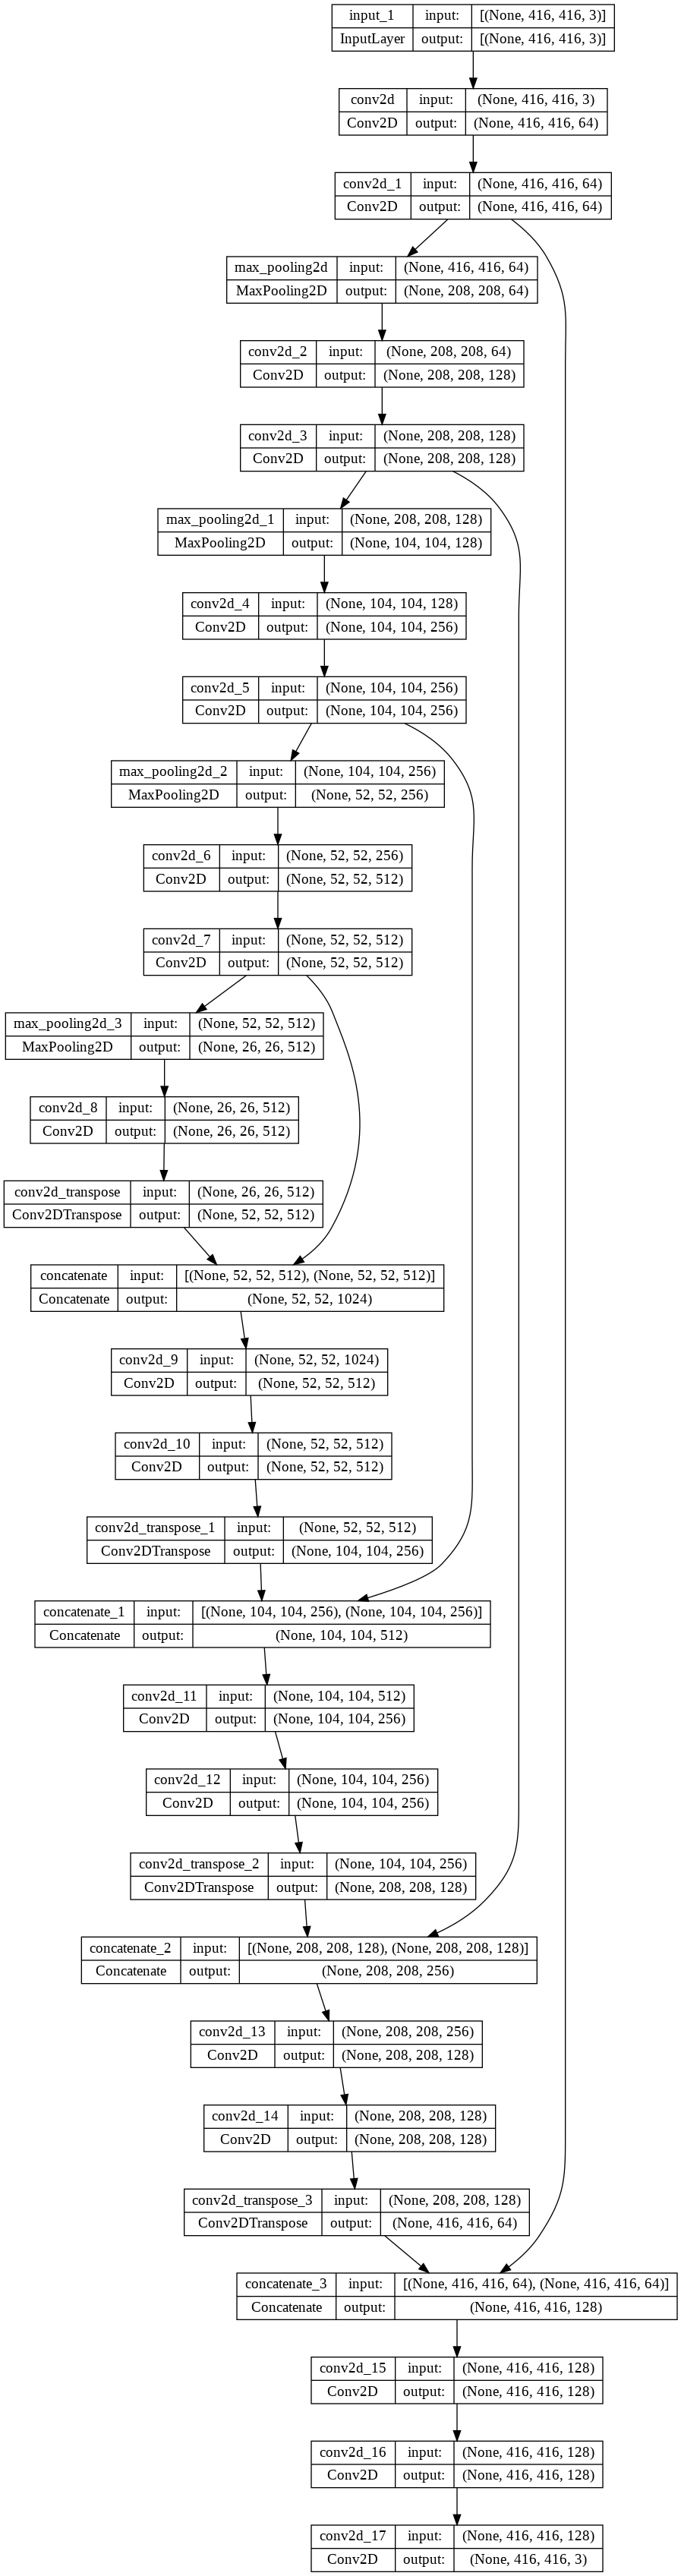

In [ ]:
tf.keras.backend.clear_session()

# 모델 구축
model = UNet(input_shape = (SIZE, SIZE, 3), num_class=NUM_CLASS)
# 모델 컴파일
model.compile(optimizer = Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['acc']
            )

model.load_weights('pretrained.h5')
plot_model(model, 'UNet_architecture.png', show_shapes=True)

In [ ]:
# save best weights
model_checkpoint = ModelCheckpoint(filepath='weights.h5',
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True,
                                   verbose=True)
# train
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=2,
    validation_split=0.3,
    callbacks=[model_checkpoint]
    )

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.3129 - acc: 0.8752
Epoch 1: val_loss improved from inf to 0.28164, saving model to weights.h5
105/105 [==============================] - 19s 68ms/step - loss: 0.3129 - acc: 0.8752 - val_loss: 0.2816 - val_acc: 0.8864
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.2658 - acc: 0.8936
Epoch 2: val_loss did not improve from 0.28164
105/105 [==============================] - 6s 61ms/step - loss: 0.2658 - acc: 0.8936 - val_loss: 0.2940 - val_acc: 0.8781
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.2630 - acc: 0.8951
Epoch 3: val_loss did not improve from 0.28164
105/105 [==============================] - 6s 61ms/step - loss: 0.2630 - acc: 0.8951 - val_loss: 0.3401 - val_acc: 0.8607
Epoch 4/10
105/105 [==============================] - ETA: 0s - loss: 0.2404 - acc: 0.9049
Epoch 4: val_loss did not improve from 0.28164
105/105 [==============================] - 6s 61ms/st

In [ ]:
model.load_weights('weights.h5')
preds = model.predict(X_test)
print(preds.shape)

6/6 [==============================] - 7s 708ms/step
(181, 416, 416, 3)


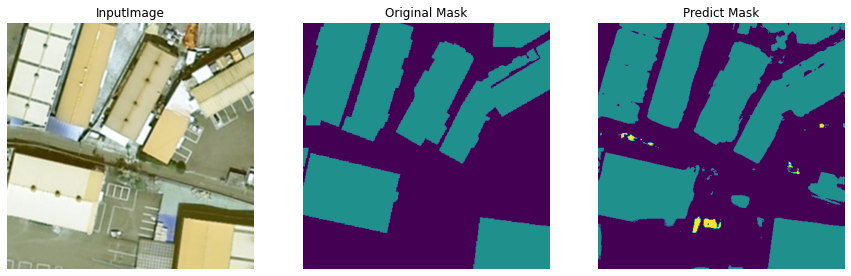

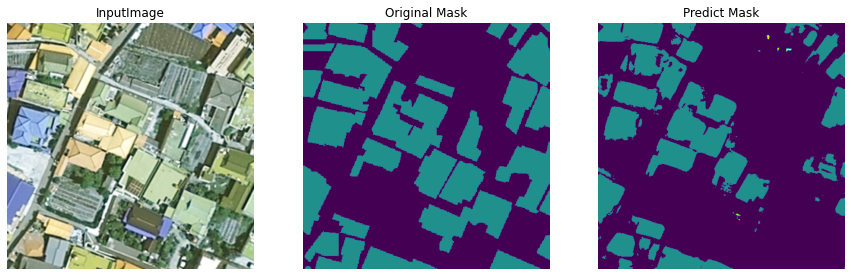

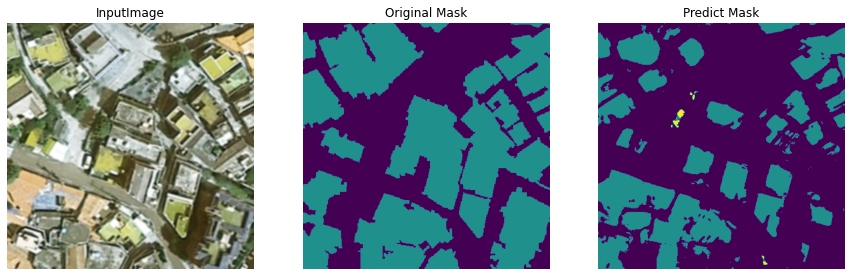

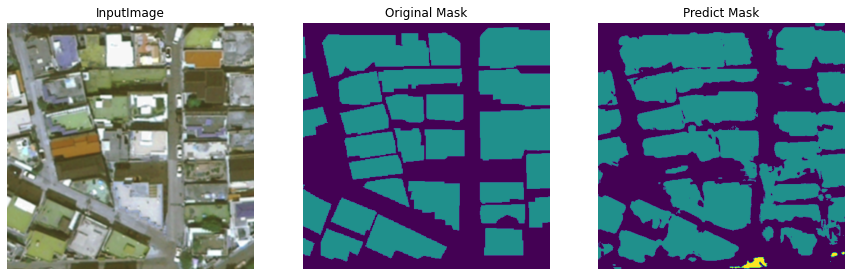

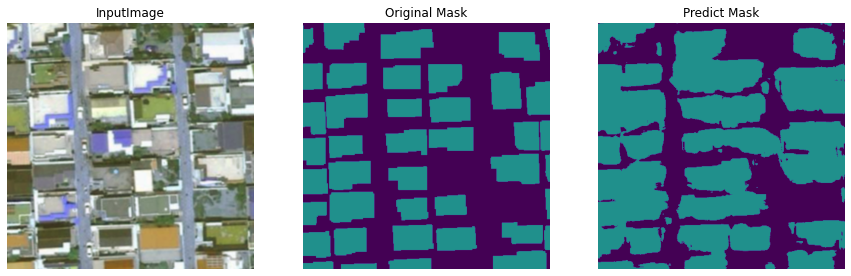

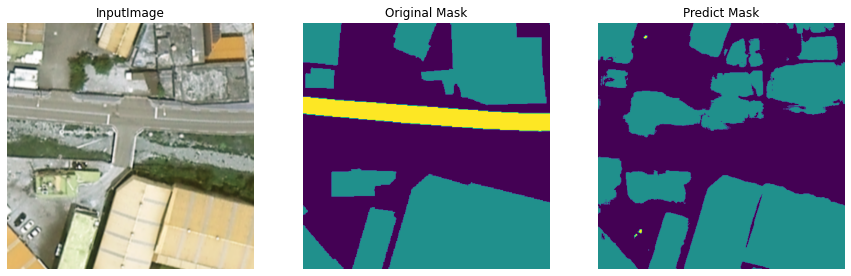

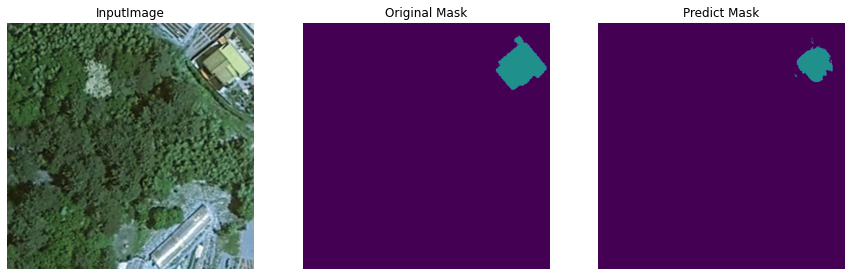

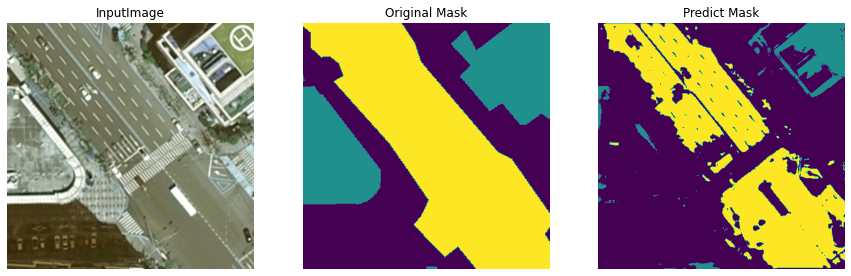

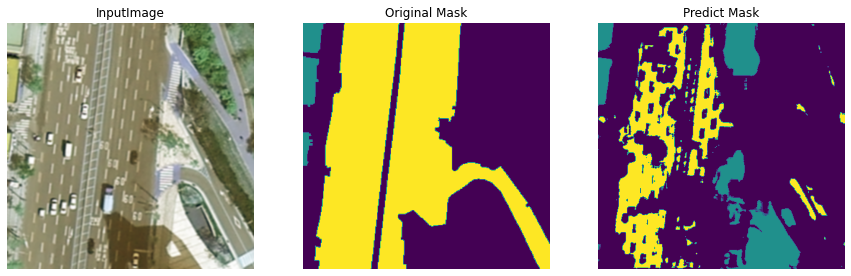

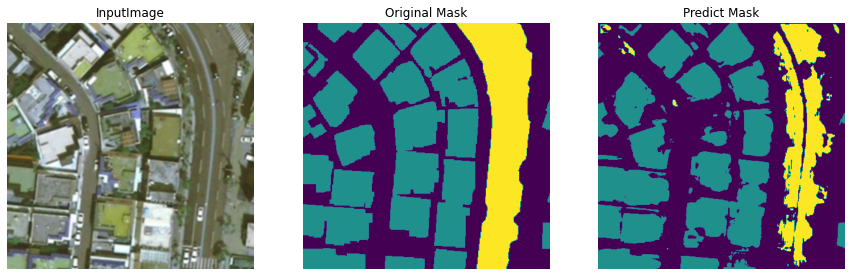

In [ ]:
for i in range(10):
    test_image = X_test[i] # input image
    pred = np.argmax(preds[i], axis=2) # result mask
    gt = y_test[i] # ground-truth mask

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.imshow(test_image)
    ax2.imshow(gt, vmin=0, vmax=2)
    ax3.imshow(pred, vmin=0, vmax=2)

    ax1.set_title('InputImage')
    ax2.set_title('Original Mask')
    ax3.set_title('Predict Mask')

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    plt.show()
    plt.close('all')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 2s 240ms/step - loss: 0.5150 - acc: 0.8198
Test loss: 0.5150217413902283
Test accuracy: 0.8198429942131042
